In [166]:
import pandas as pd
import numpy as np
import duckdb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [167]:
# Caminho do banco
db_path = "../../../data/duckdb/database.duckdb"

# Conexão com o banco DuckDB
con = duckdb.connect(db_path)

# Carrega os dados da camada bronze
df = con.execute("""
    SELECT 
          CG.*
        , CC.cluster
                 
    FROM gold.consumo_geral AS CG
    
    INNER JOIN output.clusterizacao_cliente AS CC ON
        CG.client_id = CC.client_id
""").df()

# Feature Engineering

In [168]:
def gerar_lag_features(df: pd.DataFrame, coluna_alvo: str, num_lags: int) -> pd.DataFrame:
    """
    Gera lag features para a coluna alvo em um DataFrame.

    Parâmetros:
    df (pd.DataFrame): DataFrame original.
    coluna_alvo (str): Nome da coluna alvo para gerar os lags.
    num_lags (int): Quantidade de lags a serem geradas (ex: 12 gera lag_1 até lag_12).

    Retorna:
    pd.DataFrame: DataFrame com as novas colunas de lag adicionadas.
    """
    df_copy = df.copy()
    for lag in range(1, num_lags + 1):
        df_copy[f'{coluna_alvo}_lag_{lag}'] = df_copy[coluna_alvo].shift(lag)
    return df_copy

In [169]:
def criar_features_climaticas(df):
    """
    Cria colunas de amplitude térmica, faixa de temperatura e faixa de umidade em um DataFrame.

    Espera que o DataFrame tenha colunas:
        - temperature_max
        - temperature_min
        - temperature
        - humidity
    """
    df = df.copy()

    df['temperature_max'] = df['temperature'].max()
    df['temperature_min'] = df['temperature'].min()

    # Amplitude térmica
    df['amplitude_termica'] = df['temperature_max'] - df['temperature_min']

    # Faixa de temperatura média
    def classificar_temp(temp):
        if temp < 24.356250:
            return 'baixa'
        elif temp <= 25.813333:
            return 'media'
        else:
            return 'alta'

    df['faixa_temperatura'] = df['temperature'].apply(classificar_temp)

    # Faixa de umidade
    def classificar_umidade(h):
        if h < 58.623529:
            return 'baixa'
        elif h <= 61.540625:
            return 'media'
        else:
            return 'alta'

    df['faixa_umidade'] = df['humidity'].apply(classificar_umidade)

    return df


In [170]:
df = criar_features_climaticas(df)

In [171]:
def criar_features_clientes(df):
    """
    Espera DataFrame com colunas: client_id, date (datetime) e consumption_kwh.
    Retorna um novo DataFrame com client_id, variabilidade_consumo_cliente e tendencia_consumo_cliente.
    """
    df = df.copy()
    df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())  # Facilita a regressão linear
    
    resultados = []

    for client, grupo in df.groupby('client_id'):
        # Variabilidade do consumo
        variabilidade = grupo['consumption_kwh'].std()

        # Tendência (regressão linear)
        if len(grupo) >= 2:
            X = grupo[['date_ordinal']]
            y = grupo['consumption_kwh']
            modelo = LinearRegression().fit(X, y)
            tendencia = modelo.coef_[0]  # Inclinação da reta
        else:
            tendencia = np.nan

        resultados.append({
            'client_id': client,
            'variabilidade_consumo_cliente': variabilidade,
            'tendencia_consumo_cliente': tendencia
        })

    return pd.DataFrame(resultados)


In [172]:
# 1. Geração das features por cliente
df_features_clientes = criar_features_clientes(df)

# 2. Merge com o dataframe original de consumo
df = df.merge(
    df_features_clientes,
    on='client_id',
    how='left'
)

In [173]:
faixa_temperatura = [f'temperatura_{temp}' for temp in df['faixa_temperatura'].unique().tolist()]

# Codificação da variável categórica
df = pd.get_dummies(df, columns=['faixa_temperatura'], prefix='temperatura', prefix_sep='_')

df[faixa_temperatura] = df[faixa_temperatura].astype(int)

In [174]:
faixa_umidade = [f'umidade_{temp}' for temp in df['faixa_umidade'].unique().tolist()]

# Codificação da variável categórica
df = pd.get_dummies(df, columns=['faixa_umidade'], prefix='umidade', prefix_sep='_')

df[faixa_umidade] = df[faixa_umidade].astype(int)

In [175]:
df = gerar_lag_features(df, 'temperature', 7)
df = gerar_lag_features(df, 'humidity', 7)
df = gerar_lag_features(df, 'consumption_kwh', 7)

df = df.fillna(0)

# Feature Selection

In [176]:
# 🔹 Separar variáveis

test_df = df[(df['cluster'] == '4') & (df['region'] == 'Centro')]

X = test_df.drop(['consumption_kwh','client_id','cluster','region'], axis=1).set_index('date')
y = test_df['consumption_kwh']

In [177]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def feature_selection_xgboost_regression_gain(X, y, num_features=None):
    """
    Seleção de features com XGBoost para regressão usando importância 'gain'.
    
    Parâmetros:
    -----------
    X : pd.DataFrame
        DataFrame com as variáveis independentes.
    y : pd.Series ou np.array
        Target (regressão).
    num_features : int, opcional
        Número de features que deseja selecionar (default: None, usa todas).
    
    Retorna:
    --------
    selected_features : list
        Lista das features selecionadas ordenadas por importância.
    model : XGBRegressor
        Modelo treinado para uso posterior.
    """
    # Dividir treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Definir e treinar modelo
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Avaliação
    preds = model.predict(X_test)
    score = r2_score(y_test, preds)
    print(f"R2 Score: {score:.4f}")

    # Importância das features pelo gain
    importance_dict = model.get_booster().get_score(importance_type='gain')

    # Converter para DataFrame para ordenar
    importance_df = pd.DataFrame(importance_dict.items(), columns=['feature', 'importance'])
    importance_df = importance_df.sort_values(by='importance', ascending=False)

    # Selecionar top n features
    if num_features is not None:
        importance_df = importance_df.head(num_features)

    selected_features = importance_df['feature'].tolist()

    print(f"Features selecionadas ({len(selected_features)}): {selected_features}")

    return selected_features, model

import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance_df, title='Importância das Features pelo Gain'):
    """
    Plota a importância das features em ordem decrescente.
    
    Parâmetros:
    -----------
    importance_df : pd.DataFrame
        DataFrame com colunas ['feature', 'importance'].
    title : str
        Título do gráfico.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
    plt.title(title)
    plt.xlabel('Importância (Gain)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


R2 Score: 0.1725
Features selecionadas (19): ['tendencia_consumo_cliente', 'variabilidade_consumo_cliente', 'consumption_kwh_lag_1', 'consumption_kwh_lag_2', 'humidity_lag_6', 'temperature_lag_4', 'consumption_kwh_lag_6', 'humidity_lag_7', 'humidity_lag_4', 'consumption_kwh_lag_7', 'humidity', 'consumption_kwh_lag_4', 'consumption_kwh_lag_3', 'temperatura_media', 'temperature_lag_6', 'consumption_kwh_lag_5', 'temperature_lag_7', 'temperature', 'umidade_media']


C:\Users\JoaoGuelfi\AppData\Local\Temp\ipykernel_22312\1851641868.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


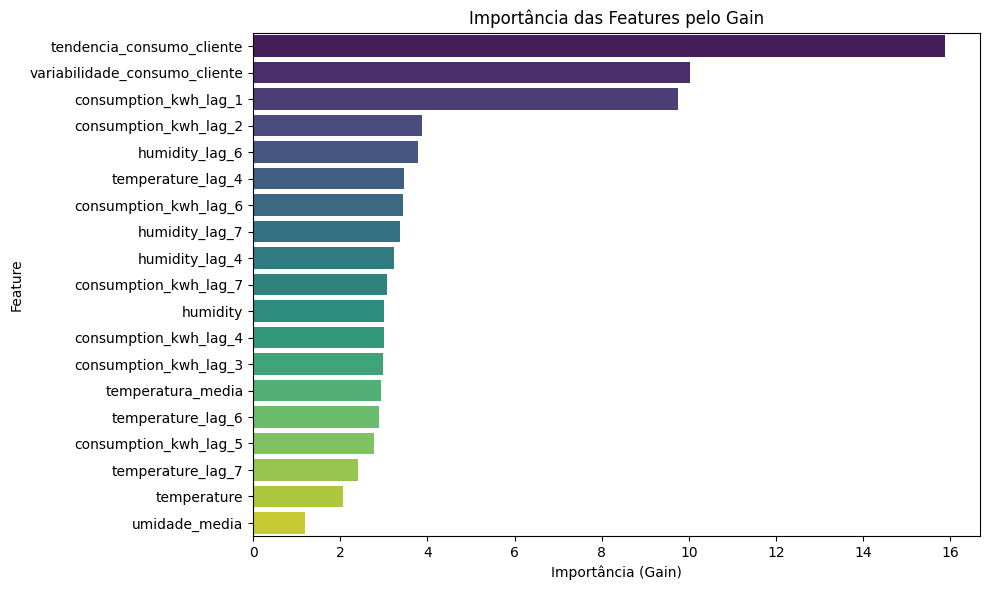

In [178]:
selected_features, modelo = feature_selection_xgboost_regression_gain(X, y, num_features=39)

# Obter o dataframe de importância para as features selecionadas
importance_dict = modelo.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(importance_dict.items(), columns=['feature', 'importance'])
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Se quiser só as top selecionadas:
importance_df = importance_df[importance_df['feature'].isin(selected_features)]

# Plotar
plot_feature_importance(importance_df)

In [ ]:
# A Feature mais importante para o modelo foi o consumo de energia do dia anterior
# O destaque foram as feature de lag de consumo de energia
# Outras features de umidade e temperature também afetam o modelo mas com ganho de informação menor que o consumo
# O range de 7 dias para lag feature mostrou-se bom período, a sazonalidade é de 1 semana

In [180]:
# Modelos e hiperparâmetros
models = {
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.05, 0.1]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'num_leaves': [31, 50]
        }
    }
}

In [181]:
# 🔹 Avaliação dos modelos
results = []

for name, config in models.items():
    
    # Define o scorer com greater_is_better=False, pois erros menores são melhores
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

    # Aplicando no GridSearchCV
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring=mape_scorer
    )
    grid.fit(X, y)
    
    best_rmse = -grid.best_score_
    best_params = grid.best_params_
    
    results.append((name, round(best_rmse, 2), best_params))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4035
[LightGBM] [Info] Number of data points in the train set: 1296, number of used features: 31
[LightGBM] [Info] Start training from score 13.052091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4043
[LightGBM] [Info] Number of data points in the train set: 1296, number of used features: 31
[LightGBM] [Info] Start training from score 13.108742
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4003
[LightGBM] [Info] Number of data points in the train set: 1296, number of used features: 31
[LightGBM] [Info] Start trai

In [182]:
# 🔹 Exibir resultados
for name, mape, params in results:
    print(f"{name} → MAPE: {mape} | Parâmetros: {params}")

XGBoost → MAPE: 0.15 | Parâmetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
RandomForest → MAPE: 0.15 | Parâmetros: {'max_depth': 5, 'n_estimators': 200}
LightGBM → MAPE: 0.16 | Parâmetros: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}
